## 1. Import Libraries & Data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, f_regression

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
colors = sns.color_palette('tab10')

pd.set_option('display.float_format', '{:.2f}'.format)
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

In [3]:
train = pd.read_csv('Data\\train.csv', 
                    parse_dates = ['date'])

train

date  store  item  sales
0      2013-01-01      1     1     13
1      2013-01-02      1     1     11
2      2013-01-03      1     1     14
3      2013-01-04      1     1     13
4      2013-01-05      1     1     10
...           ...    ...   ...    ...
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82

[913000 rows x 4 columns]

In [4]:
test = pd.read_csv('Data\\test.csv', 
                   parse_dates = ['date'])

test

id       date  store  item
0          0 2018-01-01      1     1
1          1 2018-01-02      1     1
2          2 2018-01-03      1     1
3          3 2018-01-04      1     1
4          4 2018-01-05      1     1
...      ...        ...    ...   ...
44995  44995 2018-03-27     10    50
44996  44996 2018-03-28     10    50
44997  44997 2018-03-29     10    50
44998  44998 2018-03-30     10    50
44999  44999 2018-03-31     10    50

[45000 rows x 4 columns]

In [5]:
# Make copies for plotting the graphs
train_data = train.copy()
test_data = test.copy()

## 2. Feature Engineering & Transformation

In [6]:
# Create time features
def create_time_features(data):

    data['year'] = data['date'].dt.year
    data['quarter'] = data['date'].dt.quarter
    # data['month'] = data['date'].dt.strftime('%b')
    data['month_Num'] = data['date'].dt.month
    data['day'] = data['date'].dt.day

    # Extract 'Weekday' & 'Week Day Num'
    # data['weekday'] = data['date'].dt.strftime('%a')
    data['weekday_num'] = data['date'].dt.weekday # Week start on Monday as 0

    return data

In [7]:
train = create_time_features(train)
train

date  store  item  sales  year  quarter  month_Num  day  \
0      2013-01-01      1     1     13  2013        1          1    1   
1      2013-01-02      1     1     11  2013        1          1    2   
2      2013-01-03      1     1     14  2013        1          1    3   
3      2013-01-04      1     1     13  2013        1          1    4   
4      2013-01-05      1     1     10  2013        1          1    5   
...           ...    ...   ...    ...   ...      ...        ...  ...   
912995 2017-12-27     10    50     63  2017        4         12   27   
912996 2017-12-28     10    50     59  2017        4         12   28   
912997 2017-12-29     10    50     74  2017        4         12   29   
912998 2017-12-30     10    50     62  2017        4         12   30   
912999 2017-12-31     10    50     82  2017        4         12   31   

        weekday_num  
0                 1  
1                 2  
2                 3  
3                 4  
4                 5  
...             ...  
912995            2  
912996            3  
912997            4  
912998            5  
912999            6  

[913000 rows x 9 columns]

In [8]:
test = create_time_features(test)
test

id       date  store  item  year  quarter  month_Num  day  \
0          0 2018-01-01      1     1  2018        1          1    1   
1          1 2018-01-02      1     1  2018        1          1    2   
2          2 2018-01-03      1     1  2018        1          1    3   
3          3 2018-01-04      1     1  2018        1          1    4   
4          4 2018-01-05      1     1  2018        1          1    5   
...      ...        ...    ...   ...   ...      ...        ...  ...   
44995  44995 2018-03-27     10    50  2018        1          3   27   
44996  44996 2018-03-28     10    50  2018        1          3   28   
44997  44997 2018-03-29     10    50  2018        1          3   29   
44998  44998 2018-03-30     10    50  2018        1          3   30   
44999  44999 2018-03-31     10    50  2018        1          3   31   

       weekday_num  
0                0  
1                1  
2                2  
3                3  
4                4  
...            ...  
44995            1  
44996            2  
44997            3  
44998            4  
44999            5  

[45000 rows x 9 columns]

In [9]:
# Check if a date is a weekend
def is_weekend(date):
    """
    Checks if a given date is a weekend.
    Args:
        date: A pandas Timestamp or datetime.date object.
    Returns:
        True if the date is a weekend, False otherwise.
    """

    # Weekday index starts from 0 (Monday)
    return date.weekday() >= 4  # so 4, 5 and 6 represent Friday, Saturday and Sunday

In [10]:
# Apply the function to the 'date' column
train['is_weekend'] = train['date'].apply(is_weekend)
train['is_weekend'] = train['is_weekend'].astype(int)
test

id       date  store  item  year  quarter  month_Num  day  \
0          0 2018-01-01      1     1  2018        1          1    1   
1          1 2018-01-02      1     1  2018        1          1    2   
2          2 2018-01-03      1     1  2018        1          1    3   
3          3 2018-01-04      1     1  2018        1          1    4   
4          4 2018-01-05      1     1  2018        1          1    5   
...      ...        ...    ...   ...   ...      ...        ...  ...   
44995  44995 2018-03-27     10    50  2018        1          3   27   
44996  44996 2018-03-28     10    50  2018        1          3   28   
44997  44997 2018-03-29     10    50  2018        1          3   29   
44998  44998 2018-03-30     10    50  2018        1          3   30   
44999  44999 2018-03-31     10    50  2018        1          3   31   

       weekday_num  
0                0  
1                1  
2                2  
3                3  
4                4  
...            ...  
44995            1  
44996            2  
44997            3  
44998            4  
44999            5  

[45000 rows x 9 columns]

In [11]:
# Apply the function to the 'date' column
test['is_weekend'] = test['date'].apply(is_weekend)
test['is_weekend'] = test['is_weekend'].astype(int)
test

id       date  store  item  year  quarter  month_Num  day  \
0          0 2018-01-01      1     1  2018        1          1    1   
1          1 2018-01-02      1     1  2018        1          1    2   
2          2 2018-01-03      1     1  2018        1          1    3   
3          3 2018-01-04      1     1  2018        1          1    4   
4          4 2018-01-05      1     1  2018        1          1    5   
...      ...        ...    ...   ...   ...      ...        ...  ...   
44995  44995 2018-03-27     10    50  2018        1          3   27   
44996  44996 2018-03-28     10    50  2018        1          3   28   
44997  44997 2018-03-29     10    50  2018        1          3   29   
44998  44998 2018-03-30     10    50  2018        1          3   30   
44999  44999 2018-03-31     10    50  2018        1          3   31   

       weekday_num  is_weekend  
0                0           0  
1                1           0  
2                2           0  
3                3           0  
4                4           1  
...            ...         ...  
44995            1           0  
44996            2           0  
44997            3           0  
44998            4           1  
44999            5           1  

[45000 rows x 10 columns]

### Create Dummy Features

In [12]:
# List of columns to encode (excluding 'date' and 'sales')
columns_to_encode = ['store', 'item', 'year', 'quarter', 
                     'month_Num', 'day', 'weekday_num']

# Apply the function to get dummy variables
train = pd.get_dummies(train, columns=columns_to_encode, 
                       drop_first=True, dtype=int)
train

date  sales  is_weekend  store_2  store_3  store_4  store_5  \
0      2013-01-01     13           0        0        0        0        0   
1      2013-01-02     11           0        0        0        0        0   
2      2013-01-03     14           0        0        0        0        0   
3      2013-01-04     13           1        0        0        0        0   
4      2013-01-05     10           1        0        0        0        0   
...           ...    ...         ...      ...      ...      ...      ...   
912995 2017-12-27     63           0        0        0        0        0   
912996 2017-12-28     59           0        0        0        0        0   
912997 2017-12-29     74           1        0        0        0        0   
912998 2017-12-30     62           1        0        0        0        0   
912999 2017-12-31     82           1        0        0        0        0   

        store_6  store_7  store_8  ...  day_28  day_29  day_30  day_31  \
0             0        0        0  ...       0       0       0       0   
1             0        0        0  ...       0       0       0       0   
2             0        0        0  ...       0       0       0       0   
3             0        0        0  ...       0       0       0       0   
4             0        0        0  ...       0       0       0       0   
...         ...      ...      ...  ...     ...     ...     ...     ...   
912995        0        0        0  ...       0       0       0       0   
912996        0        0        0  ...       1       0       0       0   
912997        0        0        0  ...       0       1       0       0   
912998        0        0        0  ...       0       0       1       0   
912999        0        0        0  ...       0       0       0       1   

        weekday_num_1  weekday_num_2  weekday_num_3  weekday_num_4  \
0                   1              0              0              0   
1                   0              1              0              0   
2                   0              0              1              0   
3                   0              0              0              1   
4                   0              0              0              0   
...               ...            ...            ...            ...   
912995              0              1              0              0   
912996              0              0              1              0   
912997              0              0              0              1   
912998              0              0              0              0   
912999              0              0              0              0   

        weekday_num_5  weekday_num_6  
0                   0              0  
1                   0              0  
2                   0              0  
3                   0              0  
4                   1              0  
...               ...            ...  
912995              0              0  
912996              0              0  
912997              0              0  
912998              1              0  
912999              0              1  

[913000 rows x 115 columns]

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Columns: 115 entries, date to weekday_num_6
dtypes: datetime64[ns](1), int32(113), int64(1)
memory usage: 407.5 MB


In [14]:
# Apply the function to get dummy variables
test = pd.get_dummies(test, columns=columns_to_encode, 
                       drop_first=True, dtype=int)
test

id       date  is_weekend  store_2  store_3  store_4  store_5  \
0          0 2018-01-01           0        0        0        0        0   
1          1 2018-01-02           0        0        0        0        0   
2          2 2018-01-03           0        0        0        0        0   
3          3 2018-01-04           0        0        0        0        0   
4          4 2018-01-05           1        0        0        0        0   
...      ...        ...         ...      ...      ...      ...      ...   
44995  44995 2018-03-27           0        0        0        0        0   
44996  44996 2018-03-28           0        0        0        0        0   
44997  44997 2018-03-29           0        0        0        0        0   
44998  44998 2018-03-30           1        0        0        0        0   
44999  44999 2018-03-31           1        0        0        0        0   

       store_6  store_7  store_8  ...  day_28  day_29  day_30  day_31  \
0            0        0        0  ...       0       0       0       0   
1            0        0        0  ...       0       0       0       0   
2            0        0        0  ...       0       0       0       0   
3            0        0        0  ...       0       0       0       0   
4            0        0        0  ...       0       0       0       0   
...        ...      ...      ...  ...     ...     ...     ...     ...   
44995        0        0        0  ...       0       0       0       0   
44996        0        0        0  ...       1       0       0       0   
44997        0        0        0  ...       0       1       0       0   
44998        0        0        0  ...       0       0       1       0   
44999        0        0        0  ...       0       0       0       1   

       weekday_num_1  weekday_num_2  weekday_num_3  weekday_num_4  \
0                  0              0              0              0   
1                  1              0              0              0   
2                  0              1              0              0   
3                  0              0              1              0   
4                  0              0              0              1   
...              ...            ...            ...            ...   
44995              1              0              0              0   
44996              0              1              0              0   
44997              0              0              1              0   
44998              0              0              0              1   
44999              0              0              0              0   

       weekday_num_5  weekday_num_6  
0                  0              0  
1                  0              0  
2                  0              0  
3                  0              0  
4                  0              0  
...              ...            ...  
44995              0              0  
44996              0              0  
44997              0              0  
44998              0              0  
44999              1              0  

[45000 rows x 99 columns]

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 99 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             45000 non-null  int64         
 1   date           45000 non-null  datetime64[ns]
 2   is_weekend     45000 non-null  int32         
 3   store_2        45000 non-null  int32         
 4   store_3        45000 non-null  int32         
 5   store_4        45000 non-null  int32         
 6   store_5        45000 non-null  int32         
 7   store_6        45000 non-null  int32         
 8   store_7        45000 non-null  int32         
 9   store_8        45000 non-null  int32         
 10  store_9        45000 non-null  int32         
 11  store_10       45000 non-null  int32         
 12  item_2         45000 non-null  int32         
 13  item_3         45000 non-null  int32         
 14  item_4         45000 non-null  int32         
 15  item_5         4500

In [16]:
# Reduce memory usage
def reduce_memory_usage(data):

    for col in data.columns:
        if pd.api.types.is_numeric_dtype(data[col]):
            if pd.api.types.is_integer_dtype(data[col]):
                data[col] = pd.to_numeric(data[col], downcast='integer')
            elif pd.api.types.is_float_dtype(data[col]):
                data[col] = pd.to_numeric(data[col], downcast='float')
                
    return data

In [17]:
train = reduce_memory_usage(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Columns: 115 entries, date to weekday_num_6
dtypes: datetime64[ns](1), int16(1), int8(113)
memory usage: 107.1 MB


In [18]:
train.columns

Index(['date', 'sales', 'is_weekend', 'store_2', 'store_3', 'store_4',
       'store_5', 'store_6', 'store_7', 'store_8',
       ...
       'day_28', 'day_29', 'day_30', 'day_31', 'weekday_num_1',
       'weekday_num_2', 'weekday_num_3', 'weekday_num_4', 'weekday_num_5',
       'weekday_num_6'],
      dtype='object', length=115)

In [19]:
test = reduce_memory_usage(test)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 99 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             45000 non-null  int32         
 1   date           45000 non-null  datetime64[ns]
 2   is_weekend     45000 non-null  int8          
 3   store_2        45000 non-null  int8          
 4   store_3        45000 non-null  int8          
 5   store_4        45000 non-null  int8          
 6   store_5        45000 non-null  int8          
 7   store_6        45000 non-null  int8          
 8   store_7        45000 non-null  int8          
 9   store_8        45000 non-null  int8          
 10  store_9        45000 non-null  int8          
 11  store_10       45000 non-null  int8          
 12  item_2         45000 non-null  int8          
 13  item_3         45000 non-null  int8          
 14  item_4         45000 non-null  int8          
 15  item_5         4500

## 3. XGB Regressor

### 3.1 Split Train Data into Training & Evaluation Sets

In [20]:
# Split the train data into two sets
train_df = train[(train["date"] < "2017-01-01")]
eval_df = train[(train["date"] >= "2017-01-01") & (train["date"] < "2018-01-01")]

In [21]:
print(train_df.shape, eval_df.shape)

(730500, 115) (182500, 115)


In [22]:
X_train = train_df.drop(['date', 'sales'], axis=1)
y_train = train_df['sales']

X_eval = eval_df.drop(['date', 'sales'], axis=1)
y_eval = eval_df['sales']

print(X_train.shape, y_train.shape)
print(X_eval.shape, y_eval.shape)

(730500, 113) (730500,)
(182500, 113) (182500,)


### 3.2 Baseline Model

In [23]:
xgb_reg = XGBRegressor(random_state=42)

# Train and evaluate the model
xgb_reg.fit(X_train, y_train)

y_pred_xgb = xgb_reg.predict(X_eval)

# mse = mean_squared_error(y_eval, y_pred_xgb)
rmse = mean_squared_error(y_eval, y_pred_xgb, squared=False)
print(f'XGBRegressor RMSE: {rmse:.3f}')

XGBRegressor RMSE: 18.798


### 3.3 Baseline + Feature Selection Method

In [24]:
xgb_reg = XGBRegressor(random_state=42)

# Apply SelectPercentile for feature selection
percentile_selector = SelectPercentile(f_regression, percentile=50)
X_train_selected = percentile_selector.fit_transform(X_train, y_train)

xgb_reg.fit(X_train_selected, y_train)

X_eval_selected = percentile_selector.transform(X_eval)

y_pred_xgb = xgb_reg.predict(X_eval_selected)

rmse = mean_squared_error(y_eval, y_pred_xgb, squared=False)
print(f'XGBRegressor RMSE: {rmse:.3f}')


XGBRegressor RMSE: 16.100


### 3.4 GridSearch - Tuning the Parameters

In [41]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(random_state=42, tree_method="gpu_hist")

percentile_selector = SelectPercentile(f_regression, percentile=50)

X_train_selected = percentile_selector.fit_transform(X_train, y_train)
X_eval_selected = percentile_selector.transform(X_eval)

param_grid = {
    'n_estimators': [200, 350, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [5, 7, 10],
    'subsample': [0.7, 0.8, 0.9],
    'early_stopping_rounds': [50],
}

grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
)

grid_search.fit(X_train_selected, y_train, 
                 eval_set=[(X_train_selected, y_train), (X_eval_selected, y_eval)], verbose=True)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

best_model = grid_search.best_estimator_

y_pred_xgb = best_model.predict(X_eval_selected)

rmse = mean_squared_error(y_eval, y_pred_xgb, squared=False)
print(f'Best XGBRegressor RMSE: {rmse:.3f}')


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[0]	validation_0-rmse:27.79571	validation_1-rmse:32.73284
[1]	validation_0-rmse:27.75364	validation_1-rmse:32.69566
[2]	validation_0-rmse:27.71235	validation_1-rmse:32.65924
[3]	validation_0-rmse:27.67165	validation_1-rmse:32.62342
[4]	validation_0-rmse:27.63167	validation_1-rmse:32.58807
[5]	validation_0-rmse:27.59217	validation_1-rmse:32.55309
[6]	validation_0-rmse:27.55358	validation_1-rmse:32.51890
[7]	validation_0-rmse:27.51548	validation_1-rmse:32.48528
[8]	validation_0-rmse:27.47810	validation_1-rmse:32.45233
[9]	validation_0-rmse:27.44113	validation_1-rmse:32.41972
[10]	validation_0-rmse:27.40470	validation_1-rmse:32.38747
[11]	validation_0-rmse:27.36894	validation_1-rmse:32.35586
[12]	validation_0-rmse:27.33380	validation_1-rmse:32.32490
[13]	validation_0-rmse:27.29692	validation_1-rmse:32.29143
[14]	validation_0-rmse:27.26248	validation_1-rmse:32.26087
[15]	validation_0-rmse:27.22652	validation_1-rmse:32.22823
[16]

### Note: 

Best parameters: {'early_stopping_rounds': 50, 'learning_rate': 0.3, 
                  'max_depth': 10, 'n_estimators': 350, 'subsample': 0.9}
Best XGBRegressor RMSE: 15.947


### 3.5 Apply the Best Parameters

In [44]:
xgb_reg = XGBRegressor(random_state=42, learning_rate=0.3, 
                       max_depth=10, n_estimators=350, subsample=0.9, 
                       early_stopping_rounds=50)

percentile_selector = SelectPercentile(f_regression, percentile=50)  

X_train_selected = percentile_selector.fit_transform(X_train, y_train)
X_eval_selected = percentile_selector.transform(X_eval)

xgb_reg.fit(X_train_selected, y_train, 
            eval_set=[(X_train_selected, y_train), (X_eval_selected, y_eval)], verbose=True)

y_pred_xgb = xgb_reg.predict(X_eval_selected)

rmse = mean_squared_error(y_eval, y_pred_xgb, squared=False)
print(f'XGBRegressor RMSE: {rmse:.3f}')

[0]	validation_0-rmse:25.23360	validation_1-rmse:30.07061
[1]	validation_0-rmse:22.99551	validation_1-rmse:27.81889
[2]	validation_0-rmse:21.30752	validation_1-rmse:26.20267
[3]	validation_0-rmse:19.94502	validation_1-rmse:25.16113
[4]	validation_0-rmse:18.85718	validation_1-rmse:24.05302
[5]	validation_0-rmse:17.80765	validation_1-rmse:23.18262
[6]	validation_0-rmse:16.74021	validation_1-rmse:22.17494
[7]	validation_0-rmse:15.84628	validation_1-rmse:21.32316
[8]	validation_0-rmse:15.15558	validation_1-rmse:20.86356
[9]	validation_0-rmse:14.56670	validation_1-rmse:20.29354
[10]	validation_0-rmse:14.12726	validation_1-rmse:19.84153
[11]	validation_0-rmse:13.70413	validation_1-rmse:19.50323
[12]	validation_0-rmse:13.26747	validation_1-rmse:19.04257
[13]	validation_0-rmse:12.85708	validation_1-rmse:18.63912
[14]	validation_0-rmse:12.62225	validation_1-rmse:18.39386
[15]	validation_0-rmse:12.39505	validation_1-rmse:18.24723
[16]	validation_0-rmse:12.13485	validation_1-rmse:17.96435
[17]	va

<h5> XGBRegressor RMSE: 15.949 </h5>

In [45]:
print(f'xgb_reg.base_score: {xgb_reg.best_score}')
print(f'xgb_reg.best_iteration: {xgb_reg.best_iteration}')

xgb_reg.base_score: 15.948889216625718
xgb_reg.best_iteration: 123


### 3.6 Model Evaluation

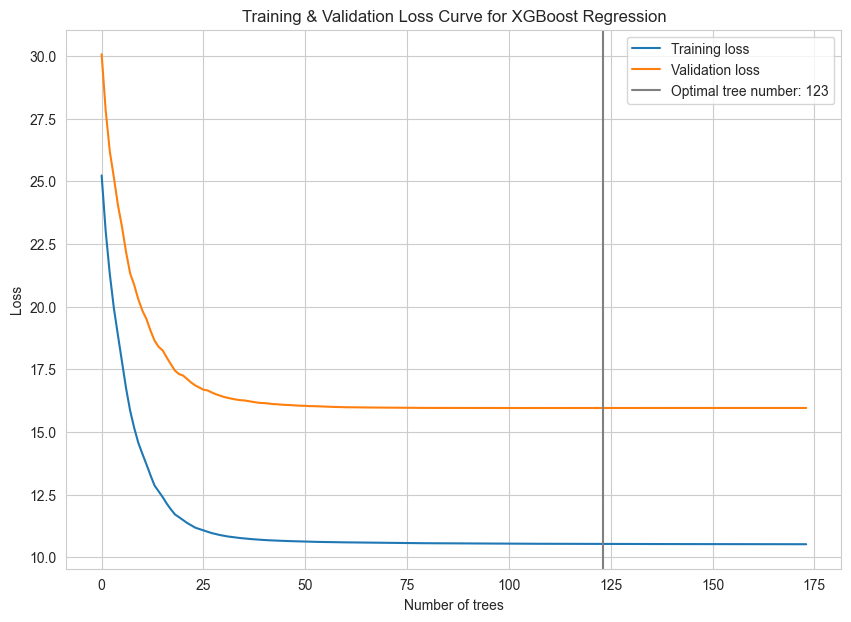

In [46]:
results = xgb_reg.evals_result()

plt.figure(figsize=(10, 7))

plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")

plt.axvline(xgb_reg.best_iteration, color='gray', 
            label=f'Optimal tree number: {xgb_reg.best_iteration:.0f}')

plt.xlabel('Number of trees')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Curve for XGBoost Regression')
plt.legend()
plt.show()

### Observations

As we can see from the plot the optimal number of tree was selected exactly before the loss values started to increase on validation dataset.    

The training was stopped. We set n_estimators=350. The optimal numer of trees is 123. 

We can check the optimal number of trees by printing the best_iteration value above.

### 3.7 Feature Importances

In [47]:
# Extract feature importances
importances = xgb_reg.feature_importances_
indices = np.argwhere(importances).ravel()
feat_names = train_df.columns[indices]

xgb_importances = pd.Series(importances, index=feat_names
                          ).sort_values(ascending=False)

print(xgb_importances[:30])

item_17    0.05
item_9     0.05
store_9    0.05
item_16    0.05
item_5     0.04
item_30    0.04
store_8    0.04
item_6     0.04
item_21    0.04
item_15    0.04
item_25    0.04
item_31    0.04
item_27    0.04
item_24    0.03
item_12    0.03
store_10   0.03
item_23    0.03
item_2     0.03
item_29    0.03
item_7     0.02
item_13    0.02
item_26    0.02
item_8     0.02
item_32    0.02
item_4     0.01
item_18    0.01
item_22    0.01
item_20    0.01
item_3     0.01
item_14    0.01
dtype: float32


In [49]:
# Extract feature importances
importances = xgb_reg.feature_importances_
indices = np.argwhere(importances).ravel()
feat_names = train_df.columns[indices]

xgb_importances = pd.Series(importances, index=feat_names
                          ).sort_values(ascending=False)

print(xgb_importances[:30])

item_17    0.05
item_9     0.05
store_9    0.05
item_16    0.05
item_5     0.04
item_30    0.04
store_8    0.04
item_6     0.04
item_21    0.04
item_15    0.04
item_25    0.04
item_31    0.04
item_27    0.04
item_24    0.03
item_12    0.03
store_10   0.03
item_23    0.03
item_2     0.03
item_29    0.03
item_7     0.02
item_13    0.02
item_26    0.02
item_8     0.02
item_32    0.02
item_4     0.01
item_18    0.01
item_22    0.01
item_20    0.01
item_3     0.01
item_14    0.01
dtype: float32


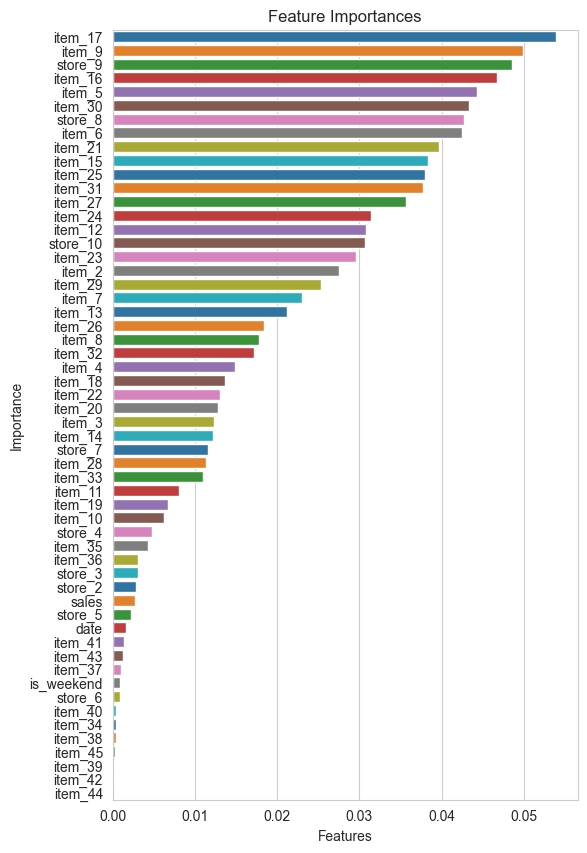

In [48]:
# Plot feature importances
plt.figure( figsize=(6, 10))
sns.barplot(y=xgb_importances.index, x=xgb_importances.values, 
            orient='h', palette='tab10')

plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

## 4. Make Predictions and Submit the Final Results

In [50]:
missing_cols = set(X_train.columns) - set(test.columns)

# Add missing columns to test and fill with 0
for col in missing_cols:
    test[col] = 0

test = test[X_train.columns]

In [51]:
# Make predictions on the test data
test_selected = percentile_selector.transform(test)

predictions = xgb_reg.predict(test_selected, 
                              iteration_range=(0, xgb_reg.best_iteration+1))
predictions

array([ 34.38,  34.38,  34.38, ...,  49.08,  58.50,  61.82], dtype=float32)

In [52]:
train_data

date  store  item  sales
0      2013-01-01      1     1     13
1      2013-01-02      1     1     11
2      2013-01-03      1     1     14
3      2013-01-04      1     1     13
4      2013-01-05      1     1     10
...           ...    ...   ...    ...
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82

[913000 rows x 4 columns]

In [53]:
test_data['sales'] = predictions
test_data

id       date  store  item  sales
0          0 2018-01-01      1     1  34.38
1          1 2018-01-02      1     1  34.38
2          2 2018-01-03      1     1  34.38
3          3 2018-01-04      1     1  34.38
4          4 2018-01-05      1     1  39.31
...      ...        ...    ...   ...    ...
44995  44995 2018-03-27     10    50  49.08
44996  44996 2018-03-28     10    50  49.08
44997  44997 2018-03-29     10    50  49.08
44998  44998 2018-03-30     10    50  58.50
44999  44999 2018-03-31     10    50  61.82

[45000 rows x 5 columns]

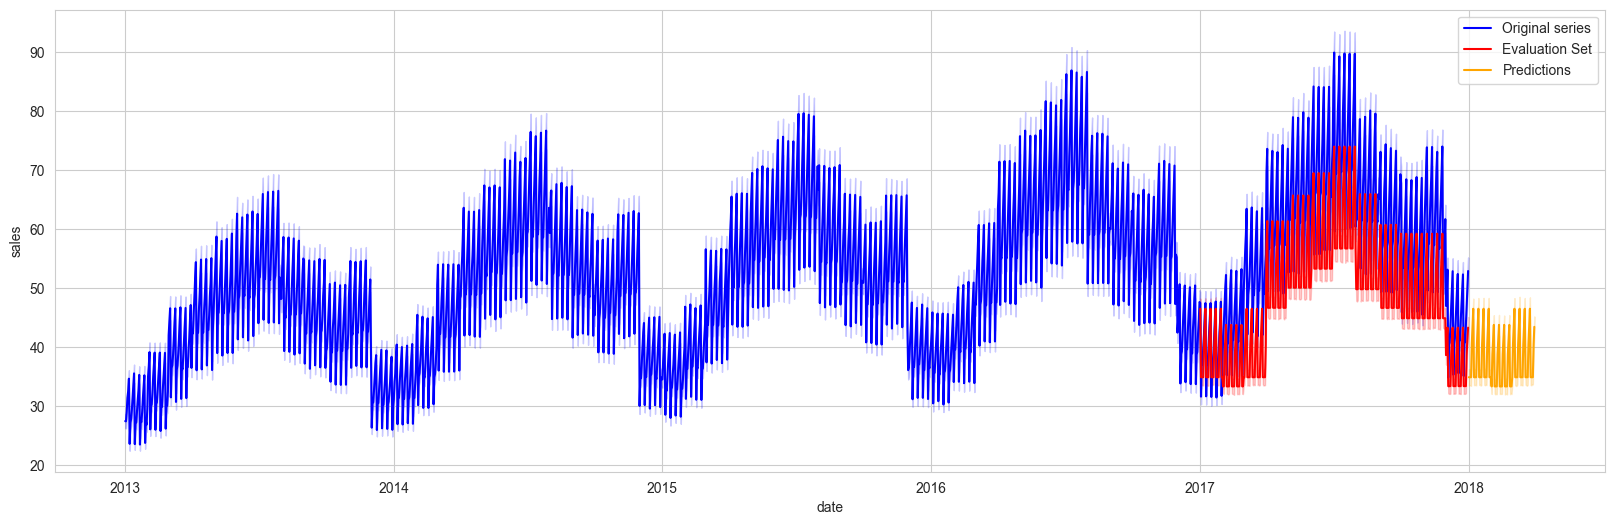

In [54]:
eval_df['predictions'] = y_pred_xgb

plt.figure(figsize=(20, 6))

# Plot the original series
sns.lineplot(data=train_data, x='date', y='sales', 
             color='blue', label='Original series')

# plot the evaluation set
sns.lineplot(data=eval_df, x='date', y='predictions', 
             color='red', label='Evaluation Set')

# plot the the test data
sns.lineplot(data=test_data, x='date', y='sales', 
             color='orange', label='Predictions')

plt.show()

In [55]:
# Predict & plot individual store-item sales
def predict_sales_plot(store_num, item_num, train_data, test_data):
    
    train_df = train_data[(train_data.store == store_num) & (train_data.item == item_num)]
    test_df = test_data[(test_data.store == store_num) & (test_data.item == item_num)]
    
    fig = plt.subplots(sharex=True, figsize=(20, 6))

    sns.lineplot(x=train_df.date, y=train_df.sales, 
                 label=f'Store {store_num} Item {item_num} Sales')
    sns.lineplot(x=test_df.date, y=test_df.sales,
                 label=f'Store {store_num} Item {item_num} Sales')
    
    plt.legend()
    plt.show()

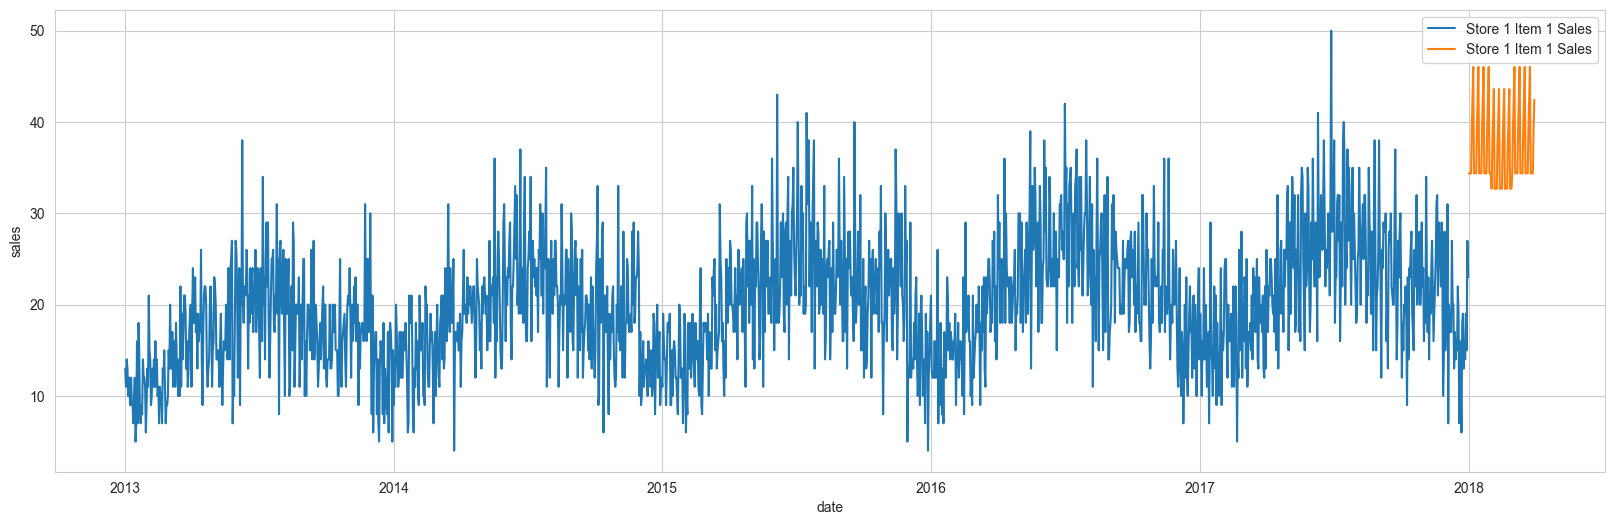

In [56]:
# Predict Store 1 & Item 1 - Sales
predict_sales_plot(store_num=1, item_num=1, train_data=train_data, test_data=test_data)

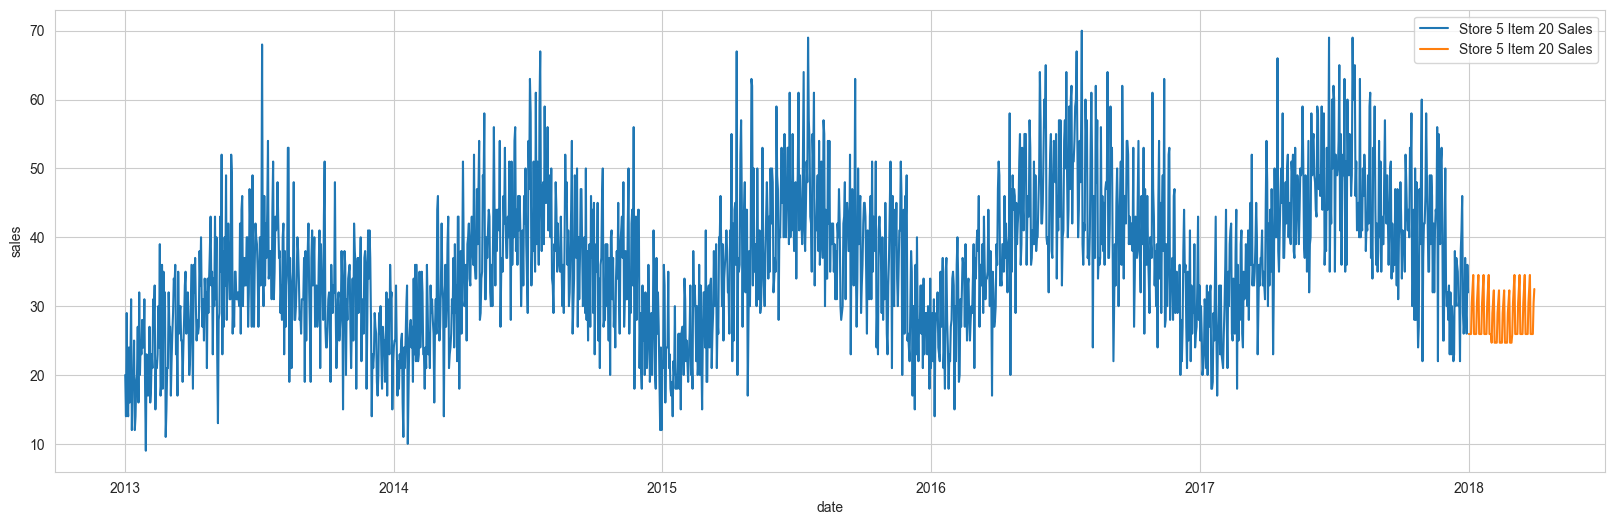

In [57]:
# Predict Store 5 & Item 20 - Sales
predict_sales_plot(store_num=5, item_num=20, train_data=train_data, test_data=test_data)

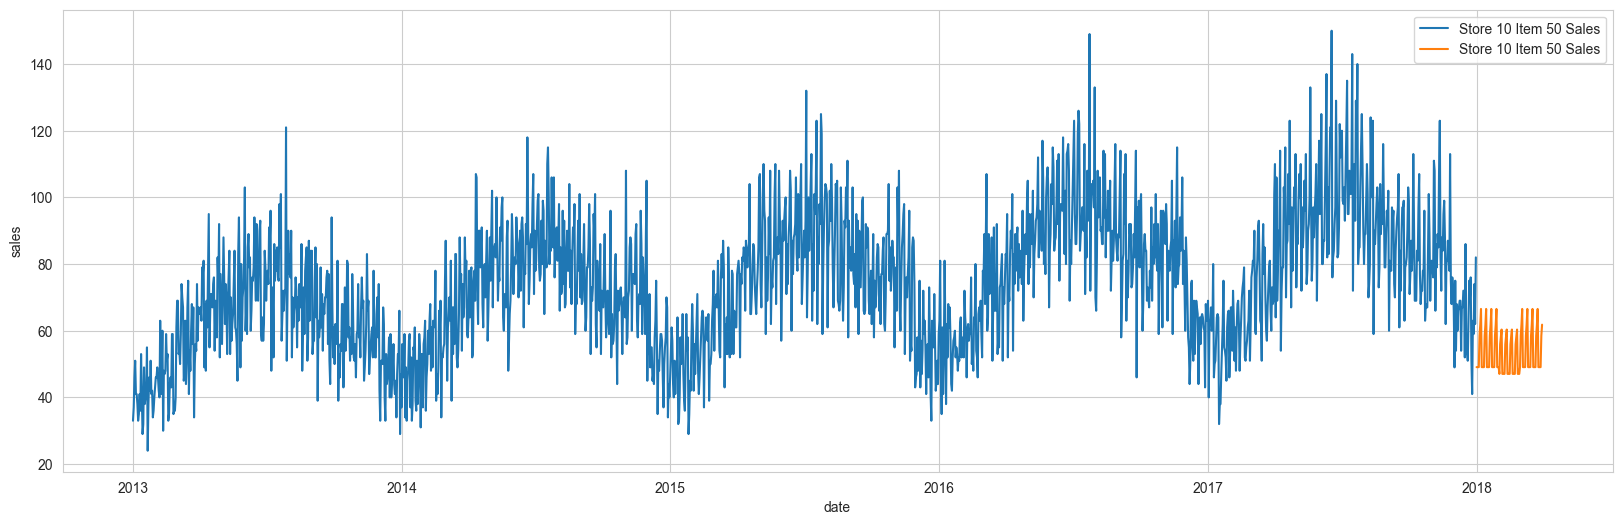

In [58]:
# Predict Store 10 & Item 50 - Sales
predict_sales_plot(store_num=10, item_num=50, train_data=train_data, test_data=test_data)

In [59]:
# Submit the final results
sample_submission = pd.read_csv('Data\sample_submission.csv')

submission_df = sample_submission.copy()
submission_df['sales'] = predictions
submission_df

id  sales
0          0  34.38
1          1  34.38
2          2  34.38
3          3  34.38
4          4  39.31
...      ...    ...
44995  44995  49.08
44996  44996  49.08
44997  44997  49.08
44998  44998  58.50
44999  44999  61.82

[45000 rows x 2 columns]

In [61]:
submission_df.to_csv("submission.csv", index=False)
print('Final results.')

Final results.
